# Motif Selection

## Discussion

## Problem

Given a collection of labelled graphs, can we:

1) Learn which features are most important for distinguishing between classes?
2) Learn a low dimensional embedding that maximizes classification accuracy while improving tractability?

## Dataset

We use the NCI1 dataset of chemical compounds that have been classified as carcinogenic or not.
It was downloaded from [TUDataset: A collection of benchmark datasets for learning with graphs](https://chrsmrrs.github.io/datasets/docs/datasets/).
There is a [leaderboard](https://paperswithcode.com/sota/graph-classification-on-nci1) evaluating graph embedding algorithms on this classification task.

### Features

A graph [motif](https://en.wikipedia.org/wiki/Network_motif) is a [vertex-induced subgraph](https://mathworld.wolfram.com/Vertex-InducedSubgraph.html).
Following `igraph` we'll only consider connected motifs.

We can construct a vector representation of a graph by counting the number of occurences of each of its motifs.
Given a family of graphs and some classification task, certain motifs may have more predictive power.
Instead of considering all motifs, can we learn a subset of motifs to count and hence reduce the amount of work we need to perform?

For these experiments node labels are ignored as `igraph`'s motif implementation does not consider them.
Using them would undoubtably increase the accuracy of the models.
It would also combinatorially increase the number of features to count,
motivating the use of Lasso or other regularization for variable selection.
In this dataset there are 37 node labels corresponding to atoms that appear in the molecules.

When not considering node labels we are not in the high dimensional case where $p > n$ (here $p = 141$ and $n = 4110$).
Ignoring isomorphisms, each of the 112 connected motifs on 6 vertices each have $37^6$ possible labellings,
giving an upper bound of roughly $2^{38}$ labelled motifs we could count.
This would place us in the high dimensional $p > n$ setting.

## Results

| Method | Accuracy | Embedding Dimension |
| :- | -: | -: |
| $C_6$ count | 0.6032 | 1 |
| `Lasso(alpha=1.0)` i.e. $P_6$ count | 0.6406 | 1 |
| `Lasso(alpha=0.1)` | 0.6438 | 3 |
| Linear Regression | 0.6672 | 141 |

## Future Work

Taking into account the vertex labels while counting motifs would likely lead to a considerable improvement in accuracy.
As there would be significantly more possible distinct objects to count this would be further reason to use Lasso.

## Experiments

### Setup

To plot graphs the `cairo` 2D graphics library is required.
It can be installed on Linux by running
```shell
sudo apt install libcairo2-dev
```
Windows installation instructions can be found [here](https://doc.courtbouillon.org/cairocffi/stable/overview.html#installing-cairo-on-windows).

If using `pip` instead of `pipenv` for dependency management, uncomment and run the below cell.

In [1]:
# ! pip install --quiet igraph cairocffi

In [2]:
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
import pickle

import igraph
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import sklearn.linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression
from tqdm import tqdm

In [3]:
sns.set()

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    """Plots the confusion matrix.
    """
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        cmap=plt.cm.Blues, im_kw={"vmin": 0, "vmax": (max(subgraph_labels)+1)/2}, ax=axs[0],
    )
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, normalize="true",
        cmap=plt.cm.Blues, im_kw={"vmin": 0, "vmax": 1}, ax=axs[1],
    )
    axs[0].grid(False)
    axs[1].grid(False)
    plt.tight_layout()
    plt.show()

### Load graphs

The dataset file format is described [on the TUDataset site](https://chrsmrrs.github.io/datasets/docs/format/).

In [5]:
data = Path("data")
if not data.exists():
    raise FileNotFoundError("Path to data directory not set")

In [6]:
# Make 1-based vertex names 0-based.
edges = [tuple(map(lambda x: int(x) - 1, edge.split(",")))
         for edge in (data / "NCI1/NCI1_A.txt").read_text().split()]

In [7]:
graph = igraph.Graph.TupleList(edges, directed=False)

In [8]:
# Make 1-based subgraph names 0-based.
subgraph_labels = np.array([
    int(x) - 1 for x in (data / "NCI1/NCI1_graph_indicator.txt").read_text().split()
])

In [9]:
class_labels = np.array([
    int(x) for x in (data / "NCI1/NCI1_graph_labels.txt").read_text().split()
])

In [10]:
node_labels = np.array([
    int(x) for x in (data / "NCI1/NCI1_node_labels.txt").read_text().split()
])

In [11]:
for v in graph.vs:
    v["graph"] = subgraph_labels[v["name"]]
    v["label"] = node_labels[v["name"]]

### Properties of these graphs

In [12]:
print(f"Number of graphs: {max(subgraph_labels) + 1}")

Number of graphs: 4110


In [13]:
print(f"The classes are roughly balanced: {Counter(class_labels).most_common()}")

The classes are roughly balanced: [(1, 2057), (0, 2053)]


In [14]:
print((f"The {max(subgraph_labels) + 1} graphs have "
       f"{graph.vcount():,} vertices and {graph.ecount():,} edges "
       "in total so are sparse"))

The 4110 graphs have 122,319 vertices and 265,506 edges in total so are sparse


In [15]:
print(f"Number of node labels i.e. distinct atoms present: {len(Counter(node_labels))}")

Number of node labels i.e. distinct atoms present: 37


In [16]:
# Check whether each graph is connected.
connected = np.empty(shape=(max(subgraph_labels) + 1,), dtype=bool)
for i in tqdm(range(max(subgraph_labels) + 1)):
    g = graph.subgraph(np.where(np.array(graph.vs["graph"]) == i)[0].tolist())
    connected[i] = g.is_connected()

100%|██████████| 4110/4110 [00:19<00:00, 212.79it/s]


In [17]:
print((f"{connected.sum()}/{len(connected)} ~= "
       f"{np.round(connected.sum() / len(connected), 3)} "
       "of the graphs are connected"))

3865/4110 ~= 0.94 of the graphs are connected


### Naive classifier based on number of 6-cycles

Does the presence of a cancer causing chemical as a subgraph contribute to whether a chemical causes cancer?
As a motivating example, consider benzene, i.e. a 6-cycle of carbon atoms,
which [causes cancer](https://en.wikipedia.org/wiki/Benzene#Health_effects).
Does the presence of a 6-cycle motif in a chemical graph contribute to whether it causes cancer?
We will construct and evaluate a simple classifier based on this
before trying to learn a task specific graph embedding that doesn't rely on any domain knowledge.

Note that for this experiment we are not considering vertex labels and so will overcount the true number of 6-cycles of carbon.

In [18]:
def count_k_cycles(graph: igraph.Graph, k: int) -> int:
    return graph.motifs_randesu(size=k)[igraph.Graph.Ring(k).isoclass()]

In [19]:
%%time
df = pd.DataFrame(index=tuple(set(graph.vs["graph"])), columns=(3, 4, 5, 6))
for i in tqdm(df.index):
    g = graph.subgraph(np.where(np.array(graph.vs["graph"]) == i)[0].tolist())
    for k in (3, 4, 5, 6):
        df.loc[i, k] = count_k_cycles(g, k)
df["class"] = class_labels

100%|██████████| 4110/4110 [00:20<00:00, 196.90it/s]

CPU times: user 20.9 s, sys: 147 ms, total: 21.1 s
Wall time: 20.9 s


In [20]:
df_6_cycle = df.groupby([6, "class"]).size().reset_index(name="density")
df_6_cycle["density"] = df_6_cycle["density"] / len(df["class"])

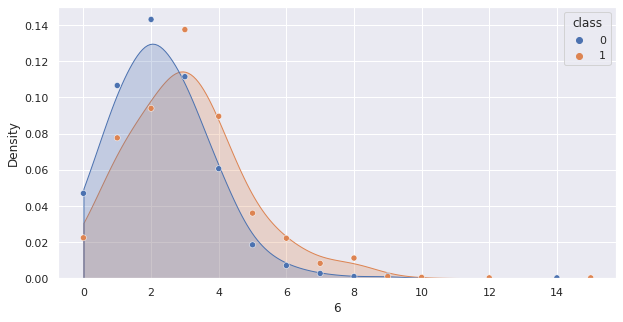

In [21]:
_, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df, x=6, hue="class", clip=(0, max(df[6])), bw_adjust=2, fill=True, ax=ax)
sns.scatterplot(data=df_6_cycle, x=6, y="density", hue="class", ax=ax)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

The two distributions don't look particularly separable.

In [22]:
y_true = df["class"].astype(bool)
y_pred_6_cycle = df[6] > 2

In [23]:
print(f"Accuracy: {np.round(accuracy_score(y_true, y_pred_6_cycle), 4)}")

Accuracy: 0.6032


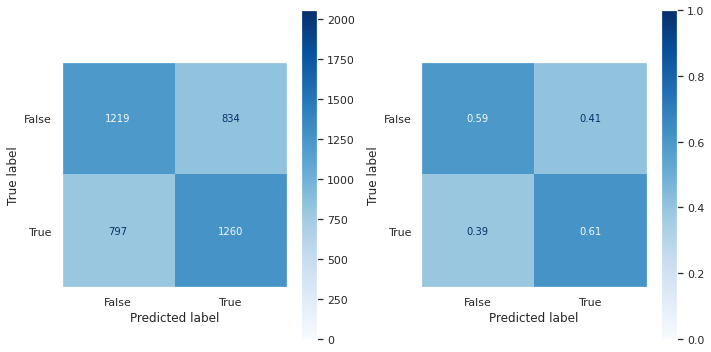

In [24]:
plot_confusion_matrix(y_true, y_pred_6_cycle)

This classifier performed quite poorly and would come last on the [leaderboard](https://paperswithcode.com/sota/graph-classification-on-nci1).
However it was incredibly simple (i.e. a 1-dimensional embedding) and the 6-cycle feature chosen by a chemistry non-expert.
Below we'll see if Lasso is able to construct a classifier that performs better, and in doing select other motifs of importance to this task.

### Motif feature selection using Lasso

The previous example required some domain knowledge to know that 6-cycles might contribute to causing cancer.

Without such domain knowledge, but with some labelled training data, can we learn the important features in a supervised way?

Can we use Lasso to decrease the number of training examples needed and increase the number of features we can consider?

In [25]:
@dataclass
class Isoclass:
    """A graph isomorphism class."""
    n: int
    cls: int
    def graph(self) -> igraph.Graph:
        """Generates a graph of this isomorphism class.
        
        https://igraph.org/python/doc/api/igraph._igraph.GraphBase.html#Isoclass
        """
        return igraph.Graph.Isoclass(n=self.n, cls=self.cls)

In [26]:
def motif_vectorizer(graph: igraph.Graph) -> list[int]:
    """Counts the number of connected motifs on 3, 4, 5, 6 vertices.
    """
    motifs = []
    for n in range(3, 6+1):
        motifs += graph.motifs_randesu(size=n)
    motifs = [x for x in motifs if not np.isnan(x)]
    return motifs

`igraph`'s [`motifs_randesu`](https://igraph.org/python/doc/api/igraph._igraph.GraphBase.html#motifs_randesu) only counts motifs of 3, 4, 5 or 6 vertices.

In addition, `igraph`'s [`motifs_randesu`](https://igraph.org/c/doc/igraph-Motifs.html#igraph_motifs_randesu) "does not count isomorphism classes that are not connected and will report NaN for them".

The number of connected motifs with $n$ vertices is just
the number of connected graphs with $n$ vertices
given by [this sequence](https://oeis.org/A001349).
Hence `igraph` can compute $2 + 6 + 21 + 112 = 141$ connected motif features.

In [27]:
assert len(motif_vectorizer(igraph.Graph())) == 141

In [28]:
def get_feature_names_out() -> tuple[Isoclass]:
    feature_names = []
    for n, n_classes in ((3, 4), (4, 11), (5, 34), (6, 156)):
        motifs = [Isoclass(n, cls) for cls in range(n_classes)]
        # Filter out disconnected motifs.
        connected = [not np.isnan(x) for x in igraph.Graph().motifs_randesu(n)]
        feature_names += [x for i, x in enumerate(motifs) if connected[i]]
    return tuple(feature_names)

In [29]:
%%time
# Vectorize each graph.
vectors = []
for i in range(max(graph.vs['graph']) + 1):
    g = graph.subgraph(np.where(np.array(graph.vs['graph']) == i)[0].tolist())
    vectors.append(motif_vectorizer(g))

CPU times: user 20.2 s, sys: 8.92 ms, total: 20.2 s
Wall time: 20.2 s


### `Lasso(alpha=1.0)`

In [30]:
reg = Lasso(alpha=1.0)
reg.fit(vectors, class_labels)
model = SelectFromModel(reg, prefit=True)

In [31]:
reg.score(vectors, class_labels)

0.10667810161121338

In [32]:
np.array(get_feature_names_out())[model.get_support()]

array([Isoclass(n=6, cls=56)], dtype=object)

In [33]:
selected_features = np.array(get_feature_names_out())[model.get_support()]

In [34]:
selected_features

array([Isoclass(n=6, cls=56)], dtype=object)

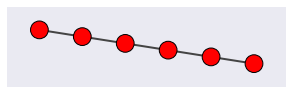

In [35]:
_, axs = plt.subplots(1, len(selected_features), figsize=(5, 5))
igraph.plot(selected_features[0].graph(), bbox=(150, 150), margin=30, target=axs)
plt.show()

Plot the distribution of counts of this selected $P_6$ path graph motif across each class.

In [36]:
df_path = pd.DataFrame({"motif_count": model.transform(vectors).flatten(),
                        "class": class_labels})
df_path_grp = df_path.groupby(["motif_count", "class"]).size().reset_index(name="density")
df_path_grp["density"] = df_path_grp["density"] / len(df_path["class"])

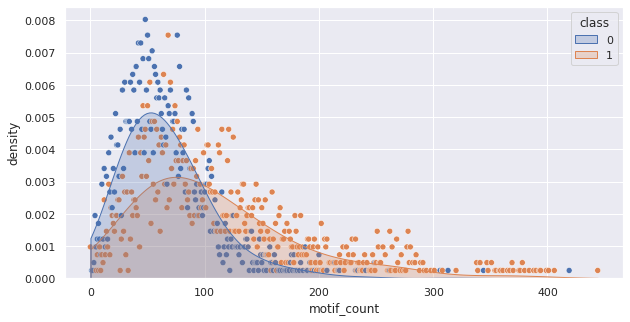

In [37]:
_, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=df_path_grp, x="motif_count", y="density", hue="class", ax=ax)
sns.kdeplot(data=df_path, x="motif_count", hue="class", clip=(0, max(df_path["motif_count"])), bw_adjust=2, fill=True, ax=ax)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

In [38]:
y_true = df["class"].astype(bool)
y_pred_lasso = np.round(reg.predict(vectors)).astype(bool)

In [39]:
print(f"Accuracy: {np.round(accuracy_score(y_true, y_pred_lasso), 4)}")

Accuracy: 0.6406


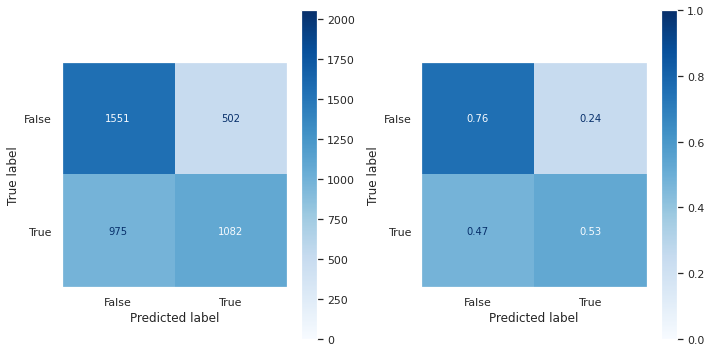

In [40]:
plot_confusion_matrix(y_true, y_pred_lasso)

### `Lasso(alpha=0.1)`

Weaker regularization than `alpha=1.0` above.

In [41]:
reg = Lasso(alpha=0.1)
reg.fit(vectors, class_labels)
model = SelectFromModel(reg, prefit=True)

In [42]:
reg.score(vectors, class_labels)

0.11748657516812411

In [43]:
np.array(get_feature_names_out())[model.get_support()]

array([Isoclass(n=6, cls=36), Isoclass(n=6, cls=56),
       Isoclass(n=6, cls=65)], dtype=object)

In [44]:
selected_features = np.array(get_feature_names_out())[model.get_support()]

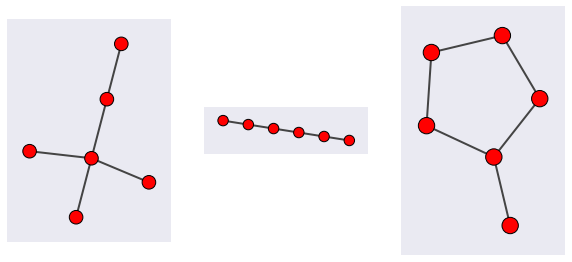

In [45]:
_, axs = plt.subplots(1, len(selected_features), figsize=(10, 30))
for i, motif in enumerate(selected_features):
    # motif.graph().plot(ax=axs[i])
    igraph.plot(motif.graph(), bbox=(250, 250), margin=30, target=axs[i])
plt.show()

The selected motifs are all sparse, which makes sense as the graphs themselves are all sparse.

In [46]:
y_true = df["class"].astype(bool)
y_pred_lasso_weak_reg = np.round(reg.predict(vectors)).astype(bool)

In [47]:
print(f"Accuracy: {np.round(accuracy_score(y_true, y_pred_lasso_weak_reg), 4)}")

Accuracy: 0.6438


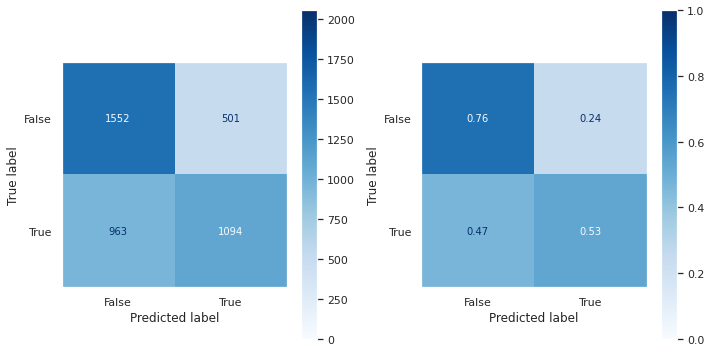

In [48]:
plot_confusion_matrix(y_true, y_pred_lasso_weak_reg)

### Linear regression

Finally, for comparison we can fit a linear regression model against all motif counts.
This will produce a much more complex model than Lasso.
In practice, computing all motif features may be undesirably expensive and 
having enough labelled training data unrealistic.

In [49]:
reg = LinearRegression()
reg.fit(vectors, class_labels)
model = SelectFromModel(reg, prefit=True)

In [50]:
y_true = df["class"].astype(bool)
y_pred_linear = np.round(reg.predict(vectors)).astype(bool)

In [51]:
print(f"Accuracy: {np.round(accuracy_score(y_true, y_pred_linear), 4)}")

Accuracy: 0.6672
